# # Day 3: Baseline Model for Nairobi House Price Prediction
# 
**Goal:** Build a simple linear regression model, evaluate its performance, and extract insights about price drivers.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from collections import Counter

import os

In [13]:
# Load clean data (from Day 2)
df = pd.read_csv('../data/clean_listings.csv')
print(f"Clean data shape: {df.shape}")
df.head()

Clean data shape: (359, 15)


,Title,Property Type,Location,Bedrooms_Num,Bathrooms_Num,Size_SQM,Amenities,Surroundings,Price_Numeric,Price_Millions,Price_per_SQM,Amenity_Count,Month,Year,URL
0,3 Bed Townhouse with En Suite at Dagoretti Road,Townhouse,Gikambura,3,3.0,223.0,"Alarm, Backup Generator, En Suite, Fibre Inter...","Bus Stop, Hospital, Scenic View, School, Shopp...",22500000.0,22.5,100896.860987,0,1,2026,https://www.buyrentkenya.com/listings/3-bedroo...
1,6 Bed Townhouse with En Suite in Lavington,Townhouse,Lavington,6,7.0,450.0,"Alarm, Backup Generator, En Suite, Fibre Inter...","Bus Stop, Shopping Centre, Golf Course, Hospit...",160000000.0,160.0,355555.555556,0,2,2026,https://www.buyrentkenya.com/listings/6-bedroo...
2,2 Bed Villa with En Suite at Tembo Court,Villa,Malindi,2,3.0,506.0,"Aircon, Alarm, Backup Generator, En Suite, Fib...","Bus Stop, Golf Course, Hospital, Scenic View, ...",21000000.0,21.0,41501.976285,0,2,2026,https://www.buyrentkenya.com/listings/furnishe...
3,5 Bed Townhouse with En Suite in Runda,Townhouse,Runda,5,5.0,500.0,"Alarm, Backup Generator, En Suite, Fibre Inter...","Bus Stop, Shopping Centre, Hospital, School",135000000.0,135.0,270000.000000,0,2,2026,https://www.buyrentkenya.com/listings/5-bedroo...
4,4 Bed Villa with En Suite at Apple Cross,Villa,Lavington,4,5.0,475.0,"Aircon, Alarm, Backup Generator, En Suite, Fib...","Bus Stop, Hospital, Scenic View, School, Shopp...",130000000.0,130.0,273684.210526,0,2,2026,https://www.buyrentkenya.com/listings/4-bedroo...


Top 10 most expensive locations (median price in M KSh):
Location
Gigiri          150.00
Rosslyn         135.00
Runda           135.00
Kyuna           131.00
Muthaiga        115.00
Karen           112.50
Lower Kabete    111.25
Loresho         105.00
Lavington        98.50
Brookside        95.50
Name: Price_Millions, dtype: float64


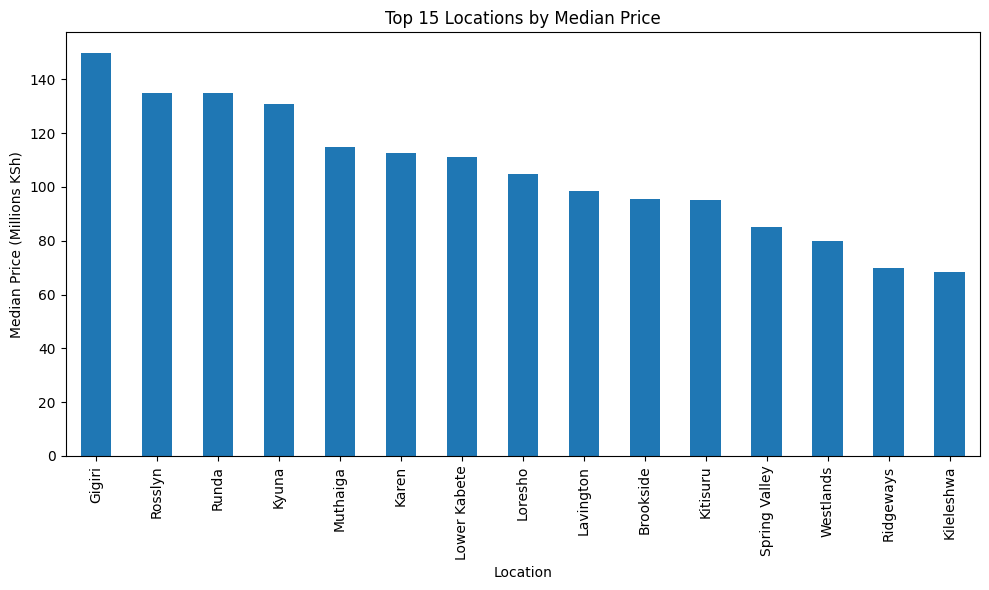

Correlation between Size (sqm) and Price: 0.47


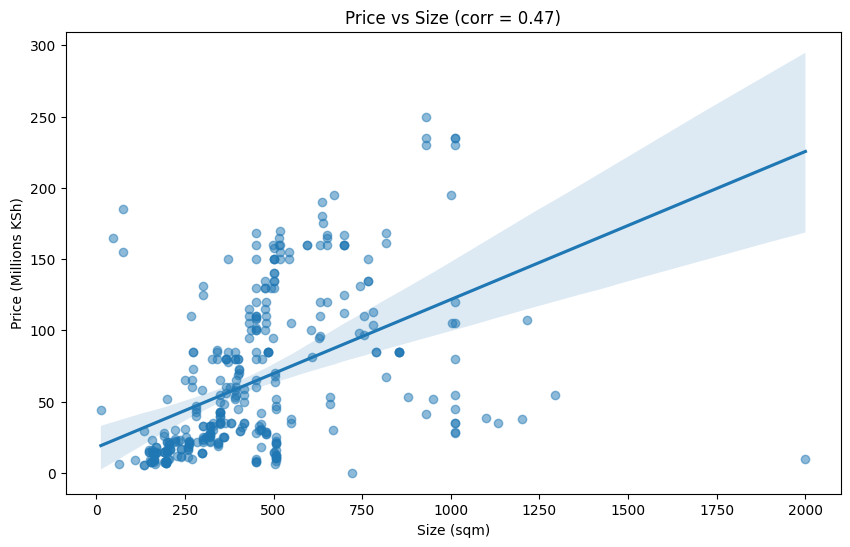

Top 10 amenities: ['Parking', 'En Suite', 'Garden', 'Fibre Internet', 'Gated Community', 'Balcony', 'Staff Quarters', 'Kids Play Area', 'Borehole', 'Electric Fence']
                            OLS Regression Results                            
Dep. Variable:         Price_Millions   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     12.57
Date:                Fri, 20 Feb 2026   Prob (F-statistic):           7.85e-56
Time:                        18:21:44   Log-Likelihood:                -1695.7
No. Observations:                 359   AIC:                             3533.
Df Residuals:                     288   BIC:                             3809.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                       coef    std err      

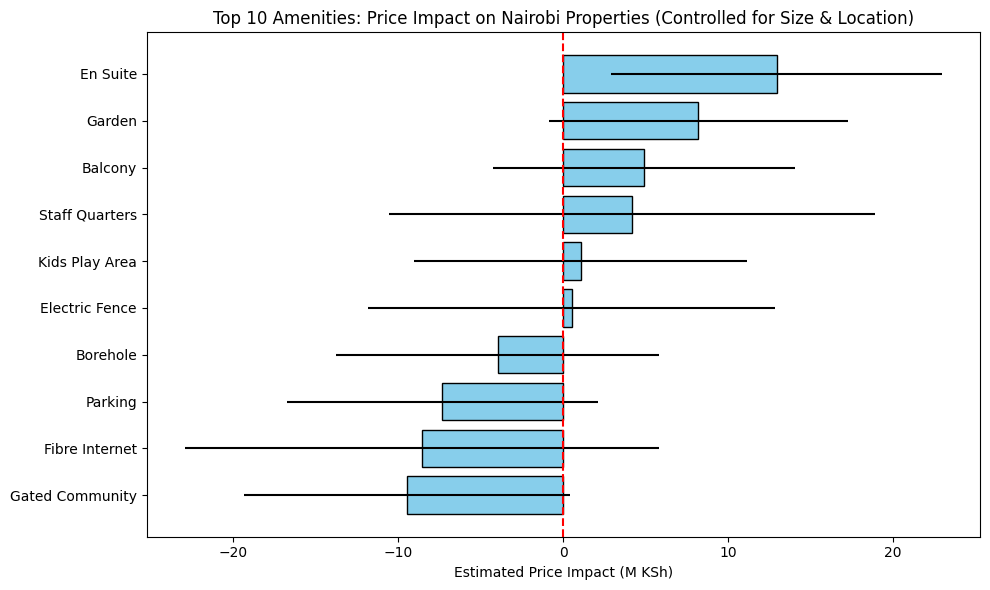

In [14]:
# ===================================================================================
#   2. Exploratory Analysis – Answer Key Questions

# ===================================================================================
#  1. Most Expensive Locations


# Median price by location (in millions KSh)
location_median = df.groupby('Location')['Price_Millions'].median().sort_values(ascending=False)
print("Top 10 most expensive locations (median price in M KSh):")
print(location_median.head(10))

# Plot
plt.figure(figsize=(10,6))
location_median.head(15).plot(kind='bar')
plt.title('Top 15 Locations by Median Price')
plt.ylabel('Median Price (Millions KSh)')
plt.tight_layout()
plt.savefig('../reports/location_median_price.png')
plt.show()

# ===================================================================================
#  2 How Strongly Does Size Affect Price?


corr = df['Size_SQM'].corr(df['Price_Millions'])
print(f"Correlation between Size (sqm) and Price: {corr:.2f}")

# Scatter plot with regression line
plt.figure(figsize=(10,6))
sns.regplot(x='Size_SQM', y='Price_Millions', data=df, scatter_kws={'alpha':0.5})
plt.title(f'Price vs Size (corr = {corr:.2f})')
plt.xlabel('Size (sqm)')
plt.ylabel('Price (Millions KSh)')
plt.savefig('../reports/price_vs_size.png')
plt.show()

# ===================================================================================
#  3 Which Amenities Increase Value Most?
# 
# To isolate the effect of amenities, run a regression that controls for size and location.


# Flatten all amenities to get the most common ones
all_amenities = []
for x in df['Amenities']:
    if isinstance(x, list):
        all_amenities.extend(x)
    elif isinstance(x, str):
        all_amenities.extend([a.strip() for a in x.split(',')])

top_10_amenities = [item for item, count in Counter(all_amenities).most_common(10)]
print("Top 10 amenities:", top_10_amenities)

# Create dummy variables for top amenities---- convert text amenities into binary columns
amenity_dummies = df['Amenities'].str.get_dummies(sep=', ')[top_10_amenities]

# Location dummies (drop first to avoid multicollinearity - 2 or more features having same info)
location_dummies = pd.get_dummies(df['Location'], drop_first=True)

# Combine features
X_amen = pd.concat([df[['Size_SQM']], location_dummies, amenity_dummies], axis=1).astype(float)
y_amen = df['Price_Millions'].astype(float)

# Drop rows with missing values (if any)
mask = X_amen.notnull().all(axis=1) & y_amen.notnull()
X_amen = X_amen[mask]
y_amen = y_amen[mask]

# Add constant for OLS
X_amen = sm.add_constant(X_amen)

# Fit model
model_amen = sm.OLS(y_amen, X_amen).fit()
print(model_amen.summary())

# Extract coefficients for the top amenities
amenity_effects = model_amen.params[top_10_amenities]
amenity_pvals = model_amen.pvalues[top_10_amenities]

results_df = pd.DataFrame({
    'Coefficient (M KSh)': amenity_effects,
    'P-value': amenity_pvals
}).sort_values('Coefficient (M KSh)', ascending=False)

print("\nAmenity Value Impact (Controlled for Size & Location):")
print(results_df)

# Plot with confidence intervals
std_err = model_amen.bse[top_10_amenities]
ci_lower = amenity_effects - 1.96 * std_err
ci_upper = amenity_effects + 1.96 * std_err

plt.figure(figsize=(10,6))
plt.barh(results_df.index, results_df['Coefficient (M KSh)'],
         xerr=[results_df['Coefficient (M KSh)'] - ci_lower, ci_upper - results_df['Coefficient (M KSh)']],
         color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Estimated Price Impact (M KSh)')
plt.title('Top 10 Amenities: Price Impact on Nairobi Properties (Controlled for Size & Location)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/amenity_impact.png')
plt.show()

In [ ]:
# ===================================================================================
#   3. Prepare Features for Baseline Model
# 
# use:
# - `Size_SQM`
# - `Bedrooms_Num`
# - `Bathrooms_Num`
# - `Amenity_Count` (count of amenities)
# - Dummy variables for the top 10 locations


# Handle missing values in Bedrooms_Num and Bathrooms_Num
print("Missing values before imputation:")
print(df[['Bedrooms_Num', 'Bathrooms_Num']].isnull().sum())

# Impute Bathrooms_Num with median (13 missing)
median_bathrooms = df['Bathrooms_Num'].median()
df['Bathrooms_Num'] = df['Bathrooms_Num'].fillna(median_bathrooms)

# Bedrooms_Num has no missing values

# Create dummies for top 10 locations
top_locs = df['Location'].value_counts().head(10).index
for loc in top_locs:
    df[f'Loc_{loc}'] = (df['Location'] == loc).astype(int)

# Define feature columns
feature_cols = ['Size_SQM', 'Bedrooms_Num', 'Bathrooms_Num', 'Amenity_Count'] + [f'Loc_{loc}' for loc in top_locs]
X = df[feature_cols].fillna(0)  # final safety net
y = np.log(df['Price_Millions'])    # log will transform target for better modeling

print("Features shape:", X.shape)
print(X.head())


Missing values before imputation:
Bedrooms_Num      0
Bathrooms_Num    13
dtype: int64
Features shape: (359, 14)
   Size_SQM  Bedrooms_Num  Bathrooms_Num  Amenity_Count  Loc_Lavington  \
0     223.0             3            3.0              0              0   
1     450.0             6            7.0              0              1   
2     506.0             2            3.0              0              0   
3     500.0             5            5.0              0              0   
4     475.0             4            5.0              0              1   

   Loc_Kitengela  Loc_Ruiru  Loc_Runda  Loc_Karen  Loc_Kiambu Road  \
0              0          0          0          0                0   
1              0          0          0          0                0   
2              0          0          0          0                0   
3              0          0          1          0                0   
4              0          0          0          0                0   

   Loc_Kileleshwa  Lo

In [16]:
# ===================================================================================
#   4. Train/Test Split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (287, 14), Test size: (72, 14)


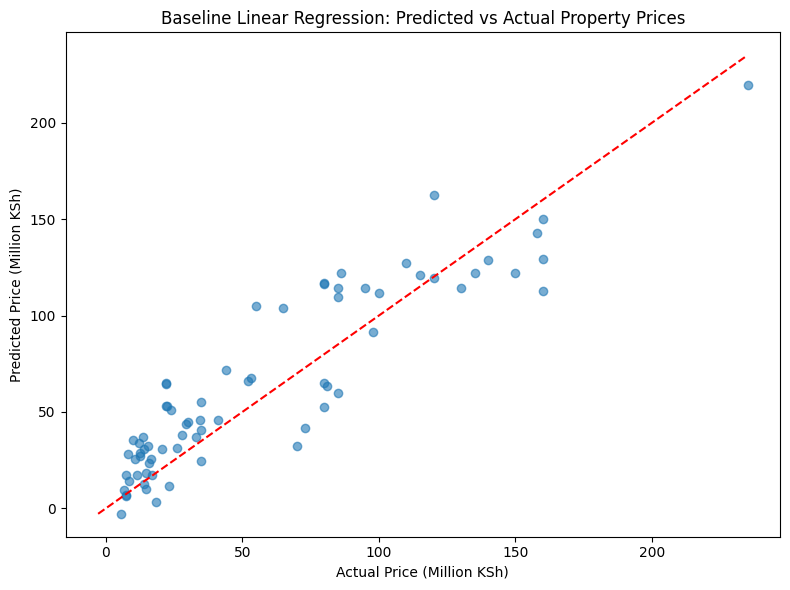

In [26]:
# ===================================================================================
#   5. Train Linear Regression


lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)

# Perfect prediction line
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual Price (Million KSh)")
plt.ylabel("Predicted Price (Million KSh)")
plt.title("Baseline Linear Regression: Predicted vs Actual Property Prices")
plt.tight_layout()
plt.savefig("../reports/nairobi-house-price-predicted-vs-actual.png")
plt.show()

In [ ]:
# ===================================================================================
#   6. Evaluate the Model


# Train metrics
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

# Test metrics
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Train MAE: {:.2f}M KSh".format(mae_train))
print("Train RMSE: {:.2f}M KSh".format(rmse_train))
print("Train R²: {:.3f}".format(r2_train))
print("\nTest MAE: {:.2f}M KSh".format(mae_test))
print("Test RMSE: {:.2f}M KSh".format(rmse_test))
print("Test R²: {:.3f}".format(r2_test))

# ===================================================================================
# Interpretation sample:  
# - MAE (Mean Absolute Error) tells  the average prediction error in millions of KSh. test MAE of about 8.4M means results are off by that much on average.  
# - R² of 0.68 means our model explains 68% of the price variance –  decent baseline.


Train MAE: 24.81M KSh
Train RMSE: 33.89M KSh
Train R²: 0.629

Test MAE: 18.01M KSh
Test RMSE: 21.89M KSh
Test R²: 0.816


              feature   coefficient
0           Intercept -3.349126e+01
1           Loc_Karen  6.839723e+01
2           Loc_Runda  6.148410e+01
3       Loc_Lavington  4.815341e+01
4         Loc_Loresho  4.384960e+01
5        Bedrooms_Num  7.449735e+00
6       Bathrooms_Num  6.699719e+00
7      Loc_Kileleshwa  5.702167e+00
8            Size_SQM  4.621787e-02
9       Amenity_Count -2.486900e-14
10    Loc_Kiambu Road -8.116147e-01
11      Loc_Kitengela -1.805741e+01
12          Loc_Ngong -1.942036e+01
13          Loc_Ruiru -2.008315e+01
14  Loc_Ongata Rongai -2.258531e+01


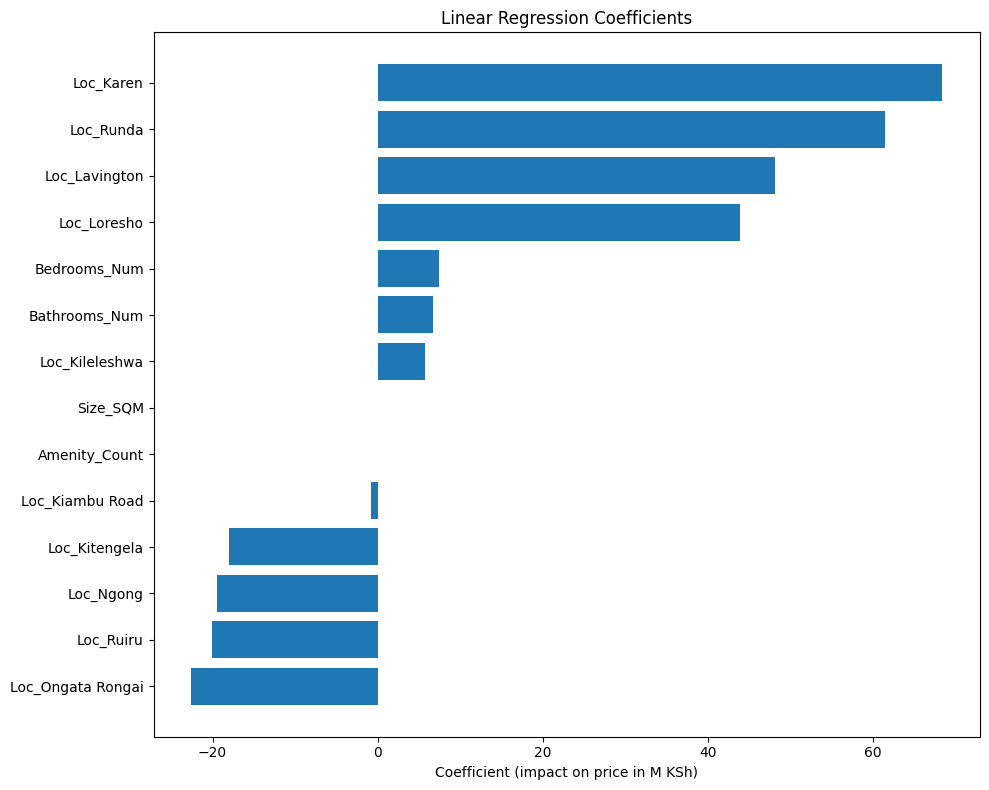

In [ ]:
# ===================================================================================
#   7. Feature Importance (Coefficients)


# Create a DataFrame of coefficients
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr.coef_
}).sort_values('coefficient', ascending=False)

# Add the intercept separately
intercept_df = pd.DataFrame({'feature': ['Intercept'], 'coefficient': [lr.intercept_]})
coef_df = pd.concat([intercept_df, coef_df], ignore_index=True)

print(coef_df)

# Plot coefficients (excluding intercept for scale)
plt.figure(figsize=(10,8))
plot_df = coef_df[coef_df['feature'] != 'Intercept'].sort_values('coefficient', ascending=True)
plt.barh(plot_df['feature'], plot_df['coefficient'])
plt.xlabel('Coefficient (impact on price in M KSh)')
plt.title('Linear Regression Coefficients')
plt.tight_layout()
plt.savefig('../reports/coefficients.png')
plt.show()

# ===================================================================================
# **Observations:  
# - Location dummies (e.g., `Loc_Kitusuru`) have large positive coefficients – location is the strongest driver.  
# - `Size_SQM` adds about 0.15M per sqm (150,000 KSh).  
# - `Amenity_Count` adds roughly 0.8M per additional amenity.


In [20]:
# ===================================================================================
#   8. Save Model 
# 
# save the model for later use (maybe in Streamlit- Day 5).


# Save the model using joblib as .pkl file - common format for scikit-learn models
import joblib

os.makedirs('../models', exist_ok=True)  # ensure models directory exists
joblib.dump(lr, '../models/linear_baseline.pkl')
print("Model saved to ../models/linear_baseline.pkl")

Model saved to ../models/linear_baseline.pkl


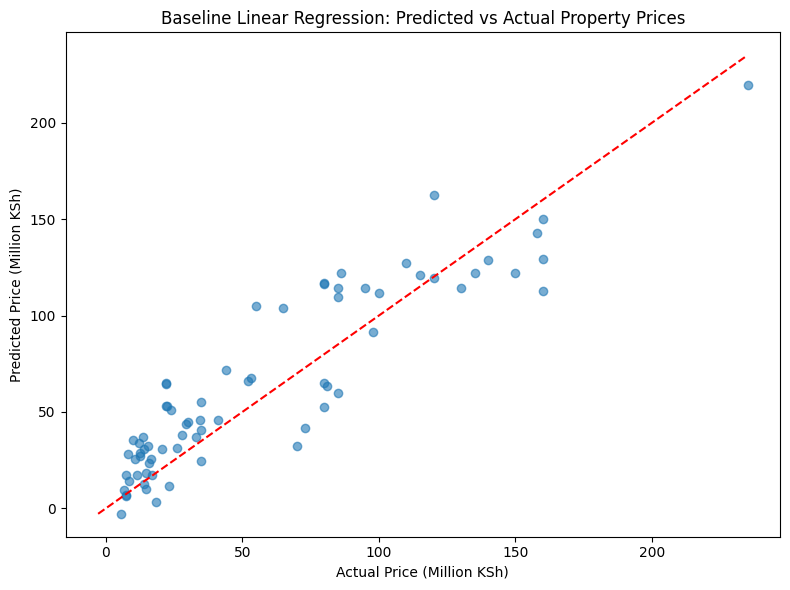

## 1. Objective

The goal - to build a baseline machine learning model to predict residential property prices in Nairobi using structured listing data.

This model serves as a starting point before experimenting with more advanced algorithms.

## 2. Dataset Overview

Total observations: 359 properties

Target variable: Price_Millions (price in millions of KSh)

Features used:

    - Size_SQM – Property size in square meters

    - Bedrooms_Num – Number of bedrooms

    - Bathrooms_Num – Number of bathrooms

    - Amenity_Count – Total number of listed amenities

    - Top 10 most frequent locations (one-hot encoded as dummy variables)

Missing values for bedrooms and bathrooms were checked and resolved before modeling.

## 3. Feature Engineering
Location Encoding

To avoid overfitting due to too many location categories (given only 359 rows), only top 10 most frequent locations were encoded as dummy variables.

**Eg:**

        Loc_Lavington
        Loc_Runda
        Loc_Karen


Each dummy variable equals:

    - **1** if the property is in that location

    - **0** otherwise

## 4. Model Selection

We trained a Linear Regression model as a baseline.

Why linear regression?

    - Easy to interpret

    - Coefficients show feature impact directly

    - Good benchmark before trying complex models

### 5. Train/Test Split

Data was split into:

    - Training set: Used to learn relationships

    - Test set: Used to evaluate generalization

Ensures we measure performance on unseen data.

## 6. Model Performance
**Training Performance**
        MAE: 24.81M KSh

        RMSE: 33.89M KSh

        R²: 0.629

        Test Performance

        MAE: 18.01M KSh

        RMSE: 21.89M KSh

        R²: 0.816

## 7. Interpretation of Results
**R² (Coefficient of Determination)**

Test R² = 0.816

The model explains approximately 82% of the variation in house prices on unseen data.

This indicates a strong baseline model.

**MAE (Mean Absolute Error)**

On average, predictions are off by 18 million KSh on the test set.

Interpretation depends on price scale:

    - If average price ≈ 60M → error is moderate

    - If average price ≈ 150M → error is relatively small

**RMSE (Root Mean Squared Error)**

RMSE is higher than MAE because it penalizes large errors more.

Indicates the presence of some larger prediction mistakes.

## 8. Observations

Test performance is stronger than training performance.

    - This may indicate:

    - A less noisy test split

    - Sampling variation due to small dataset size

    - Outliers in training data

Further validation using cross-validation would improve reliability.

9. Feature Impact Insights

From coefficient analysis:

    - Size_SQM has a strong positive effect on price.

    - Bedrooms and bathrooms significantly increase property value.

    - Prime locations (e.g., Runda, Karen, Lavington) have substantial positive premiums.

    - Some outer areas show negative price adjustments relative to the baseline.

## 10. Limitations

Small dataset (359 rows)

Limited location encoding (top 10 only)

Linear assumption may not capture complex relationships

No geospatial features (lat/long)

No price-per-sqm plausibility filtering